# Adversarial attacks using TorchANI models and data

In this notebook, we use TorchANI ([paper](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00451) and [source code](https://github.com/aiqm/torchani)) to show that adversarial attacks on uncertainty gives distinct configurations from the training data, as shown in the supporting information of [our paper](https://arxiv.org/abs/2101.11588).

The notebook uses the models with the helper functions in the `robust` folder in this repo and requires installation of the [`torchani`](https://github.com/aiqm/torchani) package.

In [ ]:
! pip install torchani
! wget https://www.dropbox.com/sh/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a/ -O download.zip
! unzip download.zip -d download || [[ $? == 2 ]]

--2021-06-02 21:19:29--  https://www.dropbox.com/sh/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a/
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a [following]
--2021-06-02 21:19:29--  https://www.dropbox.com/sh/raw/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8cad6845c8493be5be45272e7.dl.dropboxusercontent.com/zip_download_get/AzE31PibD0ty4-zKoPBgcp4Vgm_lx1SOI6Ry0q5M1RIJTBFnQciy51KN2EOW8XGs81DAmqHs6aG8v52ce6Vh6zeSDSN3aoJW9Hy0WYVtfXh2Tw# [following]
--2021-06-02 21:19:30--  https://ucb8cad6845c8493be5be45272e7.dl.dropboxusercontent.com/zip_download_get/AzE31PibD0ty4-zKoPBgcp4Vgm_lx1SOI6Ry0q5M1RIJTBFnQciy51KN2EOW8XGs81DAmqHs6aG8v52ce6Vh

In [1]:
import sys
sys.path.append('..')

import robust as rb
import torch
import torchani
import ase
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from robust.geom import compute_rmsd

# Load ANI-1x data

ANI-1x dataset contains organic molecules built from H, C, N, and O elements. In this specific file `ani_gdb_s01.h5`, there are only three unique molecules ($H_2O$, $CH_4$, and $NH_3$). 

Note that subtracting energies by the self energies of all atoms for each molecule makes the range of energies reasonable. For more information, refer to [TorchANI paper](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00451).

In [2]:
species_order = ['H', 'C', 'N', 'O']
energy_shifter = torchani.utils.EnergyShifter(None)

dspath = 'download/dataset/ani1-up_to_gdb4/ani_gdb_s01.h5'
data = torchani.data.load(dspath)
dset = list(data.subtract_self_energies(energy_shifter, species_order).species_to_indices())

# Load torchANI.ANI1ccx ensemble models

Loading ANI-1ccx models from `torchANI` package. ANI-1ccx was trained to the ANI-1x data set and then retrained to a 10% smaller data set of accurate coupled cluster calculations. 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = torchani.models.ANI1x(periodic_table_index=False).to(device)

# Perform adversarial attack 

Now we select the parameters for adversarial attacks to find configurations with high uncertainty. We randomly choose seed configurations to maximize adversarial loss on. 

In [4]:
num_attacks = 100
lr = 5e-5
kT = 0.7
n_epochs = 100

Get energy distribution for each molecule to build individual `AdvLoss` functions. 

In [5]:
ch_format = {"CHHHH": "CH4", 'NHHH': 'H3N', 'OHH': 'H2O'}
atomic_number = {'H': 1, 'C': 6, 'N': 7, 'O': 8}

In [6]:
energies = {}
for d in data:
    mol = ch_format["".join(d['species'])]
    energies[mol] = energies.get(mol, [])
    energies[mol].append(torchani.units.hartree2kcalmol(d['energies']))
    
loss_fn = {}
for mol in energies.keys():
    potential_dset = rb.PotentialDataset(
            x=np.zeros((len(energies[mol]))),
            energy=np.array(energies[mol]) - np.array(energies[mol]).min(),
            forces=np.zeros((len(energies[mol]), 3)),
    )
    loss_fn[mol] = rb.AdvLoss(train=potential_dset, temperature=kT)

Starting adversarial attack

In [7]:
def get_force_std(forces, mode='max', modeldim=0, natomdim=1, xyzdim=2):
    forces = (forces.squeeze() ** 2).sum(xyzdim)**0.5
    fstd = forces.std(modeldim)
    if mode == 'max':
        return fstd.max()
    elif mode == 'mean':
        return fstd.mean()
    
def get_force_max(forces, modeldim=0, natomdim=1, xyzdim=2):
    forces = (forces.squeeze() ** 2).sum(xyzdim)**0.5
    fstd = forces.std(modeldim)
    return forces[:, fstd.argmax()].mean()

In [8]:
batch_size = 1
seed_data = [dset[i] for i in torch.randperm(len(dset))[:num_attacks]]
loader = torchani.data.TransformableIterable(seed_data).collate(batch_size)

print("Step |     AdvLoss     | Delta  | Energy  |  Force  |  Fstd  | RMSD ")

molecules, energy, force_std, force_max, rmsd = [], [], [], [], []
for i, batch in enumerate(loader):
    species = batch['species'].to(device)
    coordinates = batch['coordinates'].to(device)
    coordinates.requires_grad = True
    
    delta = torch.zeros_like(coordinates, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([delta], lr=lr)
    
    # Get atomic numbers and coordinates of seed configuration
    z = torch.tensor(list(map(lambda x: atomic_number[species_order[x.item()]], batch['species'].squeeze())))
    orig_mol = ase.Atoms(numbers=z, 
                         positions=coordinates[:len(z)].squeeze().cpu().detach().numpy())
    v = np.concatenate([orig_mol.get_atomic_numbers().reshape(-1, 1), orig_mol.get_positions()], axis=1)
    formula = orig_mol.get_chemical_formula()

    molecules.append(formula)
    energy.append([])
    force_std.append([])
    force_max.append([])
    rmsd.append([])
    
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()

        coordinates = coordinates + delta

        results = [model((species, coordinates)) for model in models]

        pred_energies = torch.stack([torchani.units.hartree2kcalmol(r.energies) - np.array(energies[formula]).min() for r in results], dim=1)
        pred_forces = torch.stack(
            [-torch.autograd.grad(
                torchani.units.hartree2kcalmol(r.energies), coordinates, allow_unused=True, retain_graph=True
            )[0] for r in results], dim=1).squeeze()

        loss = loss_fn[formula].loss_fn(x=None, e=pred_energies, f=pred_forces).sum()

        loss.backward()
        optimizer.step()
        
        # calculate rmsd from seed configuration
        disturbed_mol = ase.Atoms(numbers=np.array(z), 
                                      positions=coordinates[:len(z)].squeeze().cpu().detach().numpy())
        w = np.concatenate([disturbed_mol.get_atomic_numbers().reshape(-1, 1), 
                            disturbed_mol.get_positions()], axis=1)
        rmsd_vw = compute_rmsd(v, w)
        
        # save values 
        energy[i].append(pred_energies.mean(-1).item())
        force_std[i].append(get_force_std(pred_forces, mode='max').detach().cpu().numpy())
        force_max[i].append(get_force_max(pred_forces).detach().cpu().numpy())
        rmsd[i].append(rmsd_vw)

        if epoch % 20 == 0:
            print("{:>4d} | {:>10.8e} | {:>5.4f} | {:>5.4f} | {:>5.4f} | {:>5.4f} | {:.4f}".format(epoch, 
                                                                                        loss.item(), 
                                                                                        delta.abs().sum().item(), 
                                                                                        pred_energies.mean(-1).item(),
                                                                                        pred_forces.abs().mean(),
                                                                                        pred_forces.std(0).mean(),
                                                                                        rmsd_vw))

Step |     AdvLoss     | Delta  | Energy  |  Force  |  Fstd  | RMSD 
   0 | -1.09142593e-02 | 0.0007 | 12.3374 | 24.6929 | 2.7067 | 0.0000
  20 | -7.23734660e-01 | 0.0144 | 9.1495 | 18.7695 | 2.2414 | 0.0150
  40 | -4.39512400e+02 | 0.0217 | 4.0032 | 14.3481 | 2.0170 | 0.0555
  60 | -2.56519986e+03 | 0.0270 | 2.4968 | 14.1121 | 2.7103 | 0.1138
  80 | -7.67260869e-01 | 0.0256 | 9.7929 | 34.8672 | 3.8260 | 0.1732
 100 | -1.51124181e-09 | 0.0266 | 24.1900 | 57.4413 | 5.0738 | 0.2350
   0 | -2.59934495e+03 | 0.0008 | 2.7640 | 16.3041 | 2.0898 | 0.0000
  20 | -3.95649164e+03 | 0.0153 | 1.1963 | 7.2082 | 1.5675 | 0.0165
  40 | -7.91452183e+03 | 0.0155 | 2.5085 | 19.7004 | 2.3377 | 0.0538
  60 | -1.11560335e+04 | 0.0184 | 1.6438 | 14.8119 | 2.1163 | 0.0807
  80 | -7.44793421e+02 | 0.0236 | 4.1530 | 20.3624 | 2.1338 | 0.0990
 100 | -1.68046824e-09 | 0.0224 | 24.2807 | 58.1733 | 3.5599 | 0.1239
   0 | -4.91201832e-03 | 0.0007 | 12.2519 | 33.6516 | 4.1762 | 0.0000
  20 | -9.77550616e-01 | 0.0144

  80 | -1.59153567e+04 | 0.0099 | 1.7416 | 18.1827 | 3.6438 | 0.0228
 100 | -6.32797910e+03 | 0.0166 | 2.3257 | 23.3859 | 4.2591 | 0.0305
   0 | -3.24670972e-08 | 0.0006 | 21.6039 | 45.0585 | 5.7034 | 0.0000
  20 | -2.35574855e-05 | 0.0114 | 16.7372 | 38.4188 | 5.2609 | 0.0162
  40 | -1.04154918e+00 | 0.0203 | 8.2176 | 23.4601 | 5.0670 | 0.0609
  60 | -9.90393382e+00 | 0.0210 | 7.7534 | 37.9332 | 4.7690 | 0.1244
  80 | -1.29450560e-02 | 0.0192 | 12.4227 | 57.1334 | 6.3970 | 0.1830
 100 | -5.48365685e-09 | 0.0190 | 22.8925 | 70.9798 | 7.1623 | 0.2420
   0 | -3.71735819e-05 | 0.0006 | 15.8397 | 34.5416 | 6.1090 | 0.0000
  20 | -7.89588967e-03 | 0.0118 | 12.0095 | 30.3243 | 5.1695 | 0.0153
  40 | -5.69697826e+02 | 0.0211 | 4.0036 | 19.9028 | 4.4123 | 0.0574
  60 | -4.38396022e+01 | 0.0267 | 5.1482 | 32.9078 | 5.0668 | 0.1217
  80 | -6.62939085e-15 | 0.0273 | 33.0429 | 111.7670 | 18.8349 | 0.1940
 100 | -2.23046346e-62 | 0.0274 | 111.0937 | 274.8762 | 85.7572 | 0.2690
   0 | -5.49446463e-0

  40 | -4.79326955e+03 | 0.0213 | 1.9977 | 13.4744 | 1.9520 | 0.0558
  60 | -1.57621275e+03 | 0.0234 | 4.1401 | 25.5160 | 3.4914 | 0.1065
  80 | -3.13265364e-01 | 0.0234 | 10.6418 | 36.2534 | 3.0642 | 0.1606
 100 | -6.68148993e-13 | 0.0237 | 30.3632 | 62.9813 | 8.4233 | 0.2212
   0 | -2.02135549e-12 | 0.0000 | 28.9224 | 45.3814 | 7.5144 | 0.0000
  20 | -5.05674454e-12 | 0.0015 | 28.2363 | 44.0748 | 7.5266 | 0.0014
  40 | -8.86049879e-09 | 0.0121 | 22.6198 | 33.4744 | 6.9612 | 0.0148
  60 | -8.61625285e-04 | 0.0242 | 13.6876 | 19.3243 | 3.8577 | 0.0577
  80 | -9.28234507e-01 | 0.0320 | 8.9399 | 19.9686 | 2.7073 | 0.1240
 100 | -5.58114110e+01 | 0.0363 | 6.1369 | 21.6985 | 2.1788 | 0.2017
   0 | -3.08159060e-04 | 0.0007 | 14.1305 | 27.8047 | 3.6457 | 0.0000
  20 | -1.02219302e-02 | 0.0147 | 10.7955 | 17.9631 | 3.4275 | 0.0164
  40 | -8.22652059e+00 | 0.0228 | 7.3272 | 21.3646 | 2.5794 | 0.0596
  60 | -7.73248029e+02 | 0.0295 | 3.8872 | 17.1006 | 1.9980 | 0.1166
  80 | -1.95455211e+02 | 0

  20 | -1.50829300e+01 | 0.0121 | 6.0539 | 17.3745 | 4.4260 | 0.0140
  40 | -1.85363306e+02 | 0.0194 | 3.9194 | 17.4489 | 4.1724 | 0.0528
  60 | -3.78972487e+03 | 0.0225 | 2.5459 | 19.9082 | 4.5791 | 0.1010
  80 | -1.71634073e+03 | 0.0245 | 2.6537 | 14.0316 | 3.2205 | 0.1491
 100 | -7.72155035e-10 | 0.0241 | 24.5597 | 64.7610 | 11.4879 | 0.2019
   0 | -2.13866728e-08 | 0.0007 | 21.8415 | 41.0647 | 3.9573 | 0.0000
  20 | -2.18860331e-05 | 0.0140 | 16.6557 | 30.5488 | 3.4047 | 0.0153
  40 | -2.32695144e-01 | 0.0224 | 9.6513 | 18.1568 | 2.4819 | 0.0578
  60 | -1.64256401e-01 | 0.0223 | 10.1077 | 32.6268 | 3.5300 | 0.1141
  80 | -1.50290205e-02 | 0.0219 | 12.8526 | 46.1539 | 4.4561 | 0.1626
 100 | -4.70822917e-07 | 0.0229 | 20.7985 | 57.5924 | 7.7779 | 0.2078
   0 | -5.64143473e+02 | 0.0006 | 4.0811 | 26.9668 | 4.8251 | 0.0000
  20 | -4.71542476e+03 | 0.0118 | 1.8414 | 11.0147 | 3.5773 | 0.0158
  40 | -1.03332558e+03 | 0.0144 | 3.2339 | 23.8879 | 4.7071 | 0.0549
  60 | -1.22695663e+01 | 0.

 100 | -1.97597612e-16 | 0.0324 | 35.9652 | 80.7107 | 10.7474 | 0.2395
   0 | -3.74348725e+00 | 0.0006 | 8.6277 | 38.0359 | 6.0730 | 0.0000
  20 | -2.18827391e+02 | 0.0122 | 4.9697 | 23.1539 | 4.3853 | 0.0157
  40 | -6.00652299e+03 | 0.0213 | 2.4351 | 17.6007 | 3.6943 | 0.0617
  60 | -1.71865667e+02 | 0.0197 | 5.2712 | 25.6453 | 3.8318 | 0.1176
  80 | -5.96097903e-04 | 0.0196 | 14.6012 | 38.2050 | 4.3942 | 0.1756
 100 | -8.16449349e-16 | 0.0197 | 34.2197 | 56.5501 | 8.5481 | 0.2378
   0 | -1.91692162e+02 | 0.0008 | 4.1659 | 16.8433 | 2.0551 | 0.0000
  20 | -2.68884553e+03 | 0.0148 | 2.2268 | 9.7608 | 1.7156 | 0.0167
  40 | -3.91746534e+03 | 0.0189 | 1.7904 | 13.6890 | 2.0648 | 0.0573
  60 | -1.17522692e+02 | 0.0213 | 4.9444 | 25.4321 | 3.4389 | 0.1012
  80 | -2.02371097e-01 | 0.0220 | 10.3117 | 30.7878 | 4.7515 | 0.1464
 100 | -2.20377732e-06 | 0.0221 | 18.7658 | 36.7887 | 6.0394 | 0.1933
   0 | -9.21904651e-01 | 0.0003 | 9.2056 | 38.3316 | 6.9145 | 0.0000
  20 | -2.99841083e+01 | 0.00

  60 | -2.94331006e+00 | 0.0138 | 8.7730 | 58.8258 | 6.0713 | 0.1048
  80 | -1.35015950e-12 | 0.0132 | 29.7607 | 123.6637 | 33.0783 | 0.1487
 100 | -9.62130759e-32 | 0.0132 | 61.3325 | 185.8180 | 62.9600 | 0.1886
   0 | -1.04899747e-01 | 0.0008 | 11.0614 | 34.2099 | 3.1865 | 0.0000
  20 | -1.53996616e+01 | 0.0143 | 6.9128 | 22.0782 | 2.7753 | 0.0161
  40 | -8.24987967e+02 | 0.0250 | 3.6436 | 16.5590 | 2.1574 | 0.0625
  60 | -4.78442204e+02 | 0.0209 | 4.7281 | 25.3157 | 2.1988 | 0.1161
  80 | -1.20162302e+03 | 0.0260 | 3.3150 | 14.9378 | 1.8091 | 0.1528
 100 | -8.00225831e-04 | 0.0279 | 14.1884 | 32.8971 | 2.6170 | 0.1747


In [9]:
energy = np.array(energy)
force_std = np.array(force_std)
force_max = np.array(force_max)
rmsd = np.array(rmsd)

# Plot evolution of mean force uncertainty and mean rmsd as a function of steps for each molecule

This plot reproduces figures S17 and S19 of the paper, up to differences in the random initialization. It essentially shows distortion of molecules to configurations that corresponds to high uncertainty (high rmsd) of the models. 

In [10]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams.update({'font.size': 14})
mpl.rc('lines', linewidth=2, color='g')
mpl.rcParams['axes.linewidth'] = 1.5 
mpl.rcParams['axes.linewidth'] = 1.5 
mpl.rcParams["xtick.major.size"] = 6 
mpl.rcParams["ytick.major.size"] = 6 
mpl.rcParams["ytick.major.width"] = 2 
mpl.rcParams["xtick.major.width"] = 2 

In [11]:
cmap = cm.inferno
COLORS = {
    "CH4": cmap(64),
    "H3N": cmap(128),
    "H2O": cmap(192),
}

MARKERS = {
    "CH4": "o",
    "H3N": "^",
    "H2O": "s",
}

ce_format = {
    "CH4": "$CH_4$",
    "H3N": "$NH_3$",
    "H2O": "$H_2O$"
}

natoms = {"CH4": 5, "H2O": 3, "H3N": 4}

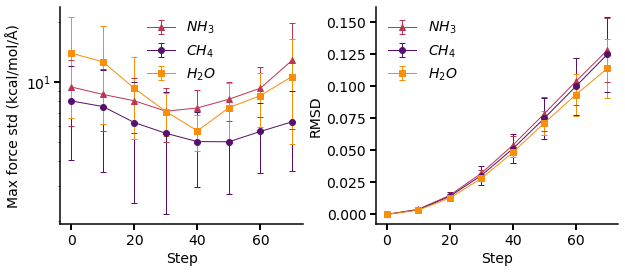

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

max_epoch = 71
interval = 10

mol_indices = {mol: [i for i, x in enumerate(molecules) if x == mol] for mol in set(molecules)}
for mol, idx in mol_indices.items():
    fstd_mean = force_std[idx].mean(0)
    fstd_std = force_std[idx].std(0)
    rmsd_mean = rmsd[idx].mean(0)
    rmsd_std = rmsd[idx].std(0)
    
    axes[0].errorbar(range(len(fstd_mean))[:max_epoch:interval], fstd_mean[:max_epoch:interval], yerr=fstd_std[:max_epoch:interval], 
                     label=ce_format[mol], color=COLORS[mol], marker=MARKERS[mol], capsize=3, linewidth=1)
    axes[1].errorbar(range(len(rmsd_mean))[:max_epoch:interval], rmsd_mean[:max_epoch:interval], yerr=rmsd_std[:max_epoch:interval],
                     label=ce_format[mol], color=COLORS[mol], marker=MARKERS[mol], capsize=3, linewidth=1)

axes[0].set_ylabel("Max force std (kcal/mol/Å)")
axes[1].set_ylabel("RMSD")

axes[0].set_yscale("log")

for ax in axes:
    ax.legend(frameon=False)
    ax.set_xlabel("Step")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.subplots_adjust(wspace=0.30)
plt.show()

This figure reproduces the one in S18 and S20 in the paper (without alanine dipeptide)

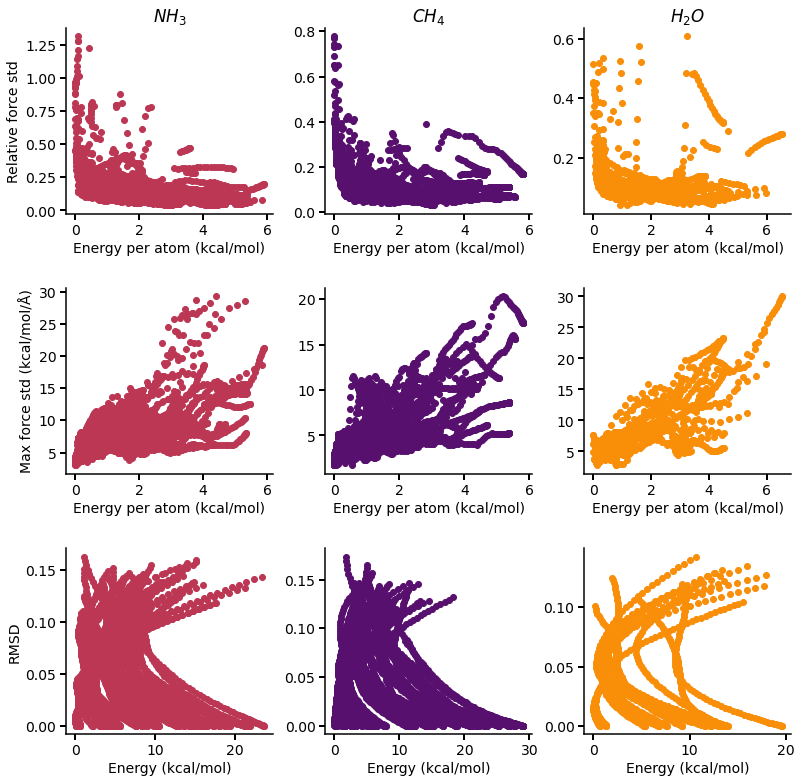

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(13, 13))

mol_indices = {mol: [i for i, x in enumerate(molecules) if x == mol] for mol in set(molecules)}
for i, (mol, idx) in enumerate(mol_indices.items()):
    axes[0, i].set_title(ce_format[mol])
    energy_mol = energy[idx][:, :max_epoch].flatten() + np.array(energies[mol]).min()
    energy_mol -= energy_mol.min() 
    energy_mol_peratom = energy_mol / natoms[mol]
    fstd = force_std[idx][:, :max_epoch]
    fmax = force_max[idx][:, :max_epoch]
    axes[0, i].scatter(energy_mol_peratom, fstd.flatten()/fmax.flatten(), color=COLORS[mol])
    axes[1, i].scatter(energy_mol_peratom, fstd, color=COLORS[mol])
    axes[2, i].scatter(energy_mol, rmsd[idx][:, :max_epoch].flatten(), color=COLORS[mol])

axes[0, 0].set_ylabel("Relative force std")
axes[1, 0].set_ylabel("Max force std (kcal/mol/Å)")
axes[2, 0].set_ylabel("RMSD")

for i in range(3):
    axes[0, i].set_xlabel("Energy per atom (kcal/mol)")
    axes[1, i].set_xlabel("Energy per atom (kcal/mol)")
    axes[2, i].set_xlabel("Energy (kcal/mol)")
    
    axes[0, i].xaxis.set_tick_params(which='both', labelbottom=True)

    for j in range(3):
        axes[j, i].spines['right'].set_visible(False)
        axes[j, i].spines['top'].set_visible(False)


fig.subplots_adjust(wspace=0.25, hspace=0.4)
plt.show()